In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import split
import pingouin as pg
from emnlp2025utils import calculate_area, get_default_policy
from emnlp2025utils import classify_economic, classify_social
from emnlp2025utils import get_largest_shape_points

## Read and Prepare Ratings (from PRISM)

In [32]:
df = pd.read_csv('../data/all_ratings_summary.csv', names=['provider', 'model', 'role', 'assessor', 'economic', 'social','neutral','refused'])
#replace 'none' with 'default' in role column
df['role'] = df['role'].replace('none', 'default').replace('', 'default')

# these models did not fully complete -- so we excluded them
exclude = ['llama2:70b', 'llama3.1','openthinker:7b']
df = df[~df['model'].isin(exclude)]

pcs = ['pcrightauth', 'pcrightlib', 'pcleftlib', 'pcleftauth', 'default', 'pcright', 'pcleft', 'pcauth', 'pclib', 'pcmoderate']
# select only the rows where the role is in pcs
df = df[df['role'].isin(pcs)]

# select only the rows where the model and role are unique
df = df.drop_duplicates(subset=['model', 'role'])
# sort the rows by model then role in place
df.sort_values(by=['model'], inplace=True)
df['model'].value_counts()

# add a column for the economic and social classification
df['economic_pos'] = df['economic'].apply(classify_economic)
df['social_pos'] = df['social'].apply(classify_social)


df['model'] = df['model'].replace({'claude-3-haiku-20240307':'claude-3-haiku',
                                    'claude-3-5-sonnet-20240620':'claude-3-5-sonnet',
                                    'deepseek-r1:latest':'deepseek-r1',
                                    'deepseek-v2:latest':'deepseek-v2',
                                    'deepscaler:latest':'deepscaler',
                                    'qwen3:latest':'qwen3',
                                    'llama4:scout': 'llama4',
                                    'gemma3:12b-it-qat':'gemma3'
                                   })


## List of Models with Ratings for each Extreme Position

In [3]:
df['model'].value_counts()

model
claude-2.1           10
claude-3-5-sonnet    10
qwen:32b             10
qwen3                10
openthinker:32b      10
mistral              10
llama4               10
llama3               10
llama2               10
gpt-4o               10
gpt-4-turbo          10
gpt-4                10
gpt-3.5-turbo        10
gemma3               10
gemini-2.0-flash     10
gemini-1.5-pro       10
gemini-1.5-flash     10
gemini-1.0-pro       10
deepseek-v2          10
deepseek-r1          10
deepscaler           10
command-r            10
command-light        10
command              10
claude-3-haiku       10
qwen:7b              10
Name: count, dtype: int64

In [33]:
# Check to make sure all the models have one of each role
#pd.crosstab(df['model'], df['role'])

In [34]:
def make_table(df):
    models = df['model'].unique()
    model_pw = []
    #print(models)
    for model in models:
        #print(model)
        # calculate the area for each model
        area = calculate_area(df, model=model)
        pct_area = (area / 400) * 100
        policy = get_default_policy(df, model=model)
        
        model_pw.append([ model, area, pct_area, policy['economic'], policy['social']])

    print(len(model_pw))

    dfm = pd.DataFrame(model_pw, columns=['model', 'area', 'pct_area', 'economic', 'social'])
    print(len(dfm))

    out = df.groupby(['model']).agg({
                            'neutral':['mean'],
                            'refused':['mean'],
                            }).reset_index()

    out.columns = ['model', 'neutral', 'refused']
    # merge the two dataframes on 'model'
    dfn = dfm.merge(out, on='model')
    dfn.columns = ['model', 'area', 'pct_area', 'def_economic', 'def_social', 'avg_neutral', 'avg_refused']
    # round all the values of float cols to 2 decimal places 
    float_cols = ['area', 'pct_area', 'def_economic', 'def_social', 'avg_neutral', 'avg_refused']
    for col in float_cols:
        dfn[col] = dfn[col].round(2)

    # apply the classification scheme to the economic and social columns in dfn
    dfn['def_economic_pos'] = dfn['def_economic'].apply(classify_economic)
    dfn['def_social_pos'] = dfn['def_social'].apply(classify_social)

    return dfn

## Table of Default Positions and POW Area

In [35]:
dfn = make_table(df)
dfn.head()

26
26


,model,area,pct_area,def_economic,def_social,avg_neutral,avg_refused,def_economic_pos,def_social_pos
0,claude-2.1,1.07,0.27,0.38,2.41,53.7,0.0,center,authoritarian
1,claude-3-5-sonnet,205.46,51.37,0.38,2.41,13.2,0.0,center,authoritarian
2,claude-3-haiku,193.00,48.25,-6.87,-4.72,3.2,0.0,left,liberal
3,command,25.15,6.29,1.44,1.05,17.5,0.0,center,center
4,command-light,22.12,5.53,-0.37,1.08,2.8,0.0,center,center


In [19]:
# make a heatmap of economic_pos and def_social_pos in df
def make_full_heatmap(df):
    # create a pivot table
    # order the columns and index
    economic_order = ['far left', 'left', 'center', 'right', 'far right']
    social_order = ['extreme authoritarian', 'authoritarian', 'center', 'liberal', 'extreme liberal']
    df['economic_pos'] = pd.Categorical(df['economic_pos'], categories=economic_order, ordered=True)
    df['social_pos'] = pd.Categorical(df['social_pos'], categories=social_order, ordered=True)
    pivot_table = df.pivot_table(index='social_pos', columns='economic_pos', values='model', aggfunc='count', fill_value=0)
    # create a heatmap
    sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
    # set the x and y axis labels
    plt.xlabel('Economic Positions')
    plt.ylabel('Social Positions')
    # set the title
    plt.title('Heatmap of Economic and Social Positions')
    plt.show()



## Heatmap of Positions

/var/folders/cq/k8rrnw1x0tl3wtccyl1nry540000gp/T/ipykernel_47497/3239726330.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(index='social_pos', columns='economic_pos', values='model', aggfunc='count', fill_value=0)


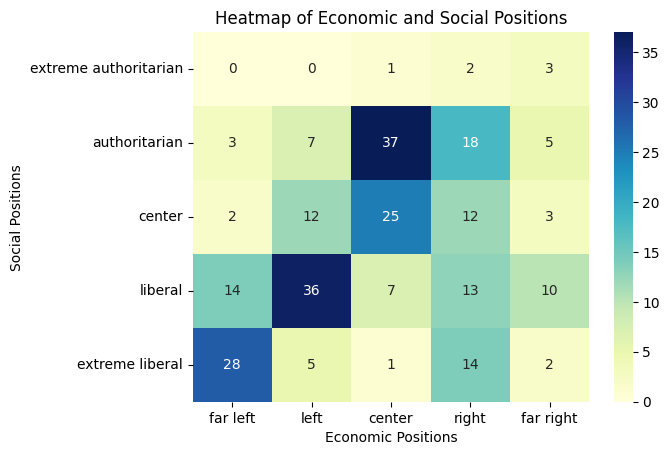

In [20]:
make_full_heatmap(df)

In [21]:
def setup_compass(plt):
    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    # make the plot -10 to 10 on both axes
    plt.set(xlim=(-10.25, 10.25))
    plt.set(ylim=(-10.25, 10.25))
    # make the top right quadrant light blue
    polygon = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])
    plt.fill(*polygon.exterior.xy, color='lightblue', alpha=0.5)
    # make the top left quadrant light red
    polygon = Polygon([(0, 0), (-10, 0), (-10, 10), (0, 10)])
    plt.fill(*polygon.exterior.xy, color='lightcoral', alpha=0.5)
    # make the bottom left quadrant light green
    polygon = Polygon([(0, 0), (-10, 0), (-10, -10), (0, -10)])
    plt.fill(*polygon.exterior.xy, color='lightgreen', alpha=0.5)
    # make the bottom right quadrant light yellow
    polygon = Polygon([(0, 0), (10, 0), (10, -10), (0, -10)])
    plt.fill(*polygon.exterior.xy, color='lightyellow', alpha=0.5)
    # add a label to the left side, "Economic Left"
    plt.text(-9.75, 0.25, "Economic Left", fontsize=9)
    # add a label to the right side, "Economic Right"
    plt.text(5.75, 0.25, "Economic Right", fontsize=9)
    # add a label to the top side, "Social Top"
    plt.text(-1.5, 9.25, "Authoritarian", fontsize=9)
    # add a label to the bottom side, "Social Bottom"
    plt.text(-1, -9.75, "Liberal", fontsize=9)

    # set xlabel to "Economic"
    plt.set_xlabel("Economic")
    # set ylabel to "Social"
    plt.set_ylabel("Social")
    # add a title to the plot
    plt.set_title("Political Compass")


def plot_provider(df, model, plot_labels=False):
    data = df[df.model == model]
    # select all the points where the role starts with 'pc' or 'default'
    data = data[data.role.str.startswith('pc') | (data.role == 'default')]
    
    plt = sns.scatterplot(data=data, x='economic', y='social', hue='model')
    setup_compass(plt)
    # plot labels
    if plot_labels:
        for i in range(data.shape[0]):
            plt.text(data.economic.iloc[i], data.social.iloc[i], str(data.role.iloc[i]), fontsize=9)
    
    # get the largest shape points
    largest_shape_points = get_largest_shape_points(data)
    for i in range(len(largest_shape_points)):
        plt.plot([largest_shape_points[i][0], largest_shape_points[(i+1)%len(largest_shape_points)][0]], [largest_shape_points[i][1], largest_shape_points[(i+1)%len(largest_shape_points)][1]], color='purple')

    
    return plt

In [22]:
def plot_providers(df, model_group, plot_labels=False):
    fig = plt.figure(figsize=(6, 6))

    # for each model in the model group, assign a color to the model
    colors = sns.color_palette("husl", len(model_group))
    color_map = {model: colors[i] for i, model in enumerate(model_group)}
    for model in model_group:


        data = df[df.model == model]
        # select all the points where the role starts with 'pc' or 'default'
        data = data[data.role.str.startswith('pc') | (data.role == 'default')]
        # plot labels
        if plot_labels:
            for i in range(data.shape[0]):
                plt.text(data.economic.iloc[i], data.social.iloc[i], str(data.role.iloc[i]), fontsize=9)
        
        # get the largest shape points
        largest_shape_points = get_largest_shape_points(data)
        for i in range(len(largest_shape_points)):
            plt.plot([largest_shape_points[i][0], 
                      largest_shape_points[(i+1)%len(largest_shape_points)][0]], 
                      [largest_shape_points[i][1], 
                       largest_shape_points[(i+1)%len(largest_shape_points)][1]], color=color_map[model], alpha=0.5)

        # shade the area of the largest shape
        polygon = Polygon(largest_shape_points)
        plt.fill(*polygon.exterior.xy, color=color_map[model], alpha=0.35)

        
        
        #setup_compass(plt)
    # add a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=model, 
                           markerfacecolor=color_map[model], markersize=10) for model in model_group]
    plt.legend(handles=handles, title='Models', loc='upper left', bbox_to_anchor=(1, 1))


    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    # make the plot -10 to 10 on both axes
    plt.xlim=(-10, 10)
    plt.ylim=(-10, 10)
    # make the top right quadrant light blue
    polygon = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])
    plt.fill(*polygon.exterior.xy, color='lightblue', alpha=0.25)
    # make the top left quadrant light red
    polygon = Polygon([(0, 0), (-10, 0), (-10, 10), (0, 10)])
    plt.fill(*polygon.exterior.xy, color='lightcoral', alpha=0.25)
    # make the bottom left quadrant light green
    polygon = Polygon([(0, 0), (-10, 0), (-10, -10), (0, -10)])
    plt.fill(*polygon.exterior.xy, color='lightgreen', alpha=0.25)
    # make the bottom right quadrant light yellow
    polygon = Polygon([(0, 0), (10, 0), (10, -10), (0, -10)])
    plt.fill(*polygon.exterior.xy, color='lightyellow', alpha=0.5)
    
    #plt.text(-9.75, 0.25, "Economic Left", fontsize=9, fontweight='bold')
    # rotate the text 90 degrees
    plt.text(-10.75, -2.25, "Economic Left", fontsize=9, fontweight='bold', rotation=90)
    # add a label to the right side, "Economic Right"
    plt.text(10.25, -2.25, "Economic Right", fontsize=9, fontweight='bold', rotation=270)
    # add a label to the top side, "Social Top"
    plt.text(-1.5, 10.25, "Authoritarian", fontsize=9, fontweight='bold')
    # add a label to the bottom side, "Social Bottom"
    plt.text(-1, -10.75, "Liberal", fontsize=9, fontweight='bold')

    plt.title("Political Compass", fontsize=16, fontweight='bold')
    plt.xlabel("Economic", fontsize=12, fontweight='bold')
    plt.ylabel("Social", fontsize=12, fontweight='bold')

    # make the x and y ticks and axis labels smaller
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tick_params(axis='both', which='minor', labelsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    return plt

models = ['claude-2.1', 'claude-3-5-sonnet',
       'claude-3-haiku', 'command', 'command-light', 'command-r',
       'deepscaler', 'deepseek-r1', 'deepseek-v2',
       'gemini-1.0-pro', 'gemini-1.5-flash', 'gemini-1.5-pro',
       'gemini-2.0-flash', 'gemma3:12b-it-qat', 'gpt-3.5-turbo', 'gpt-4',
       'gpt-4-turbo', 'gpt-4o', 'llama2', 'llama3', 'llama4:scout',
       'mistral', 'openthinker:32b', 'qwen3', 'qwen:32b',
       'qwen:7b']



## Political Overton Window Plots

<module 'matplotlib.pyplot' from '/Users/dkb16129/.virtualenvs/rag/lib/python3.11/site-packages/matplotlib/pyplot.py'>

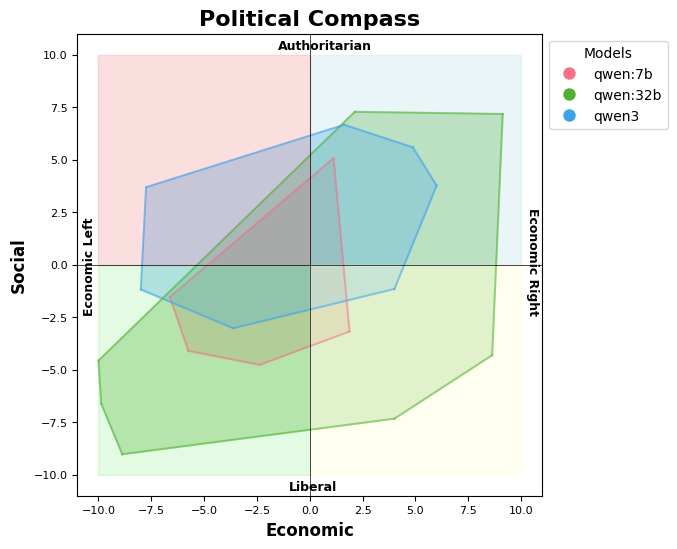

In [23]:
plot_providers(df, [ 'qwen:7b', 'qwen:32b', 'qwen3'], plot_labels=False)

<module 'matplotlib.pyplot' from '/Users/dkb16129/.virtualenvs/rag/lib/python3.11/site-packages/matplotlib/pyplot.py'>

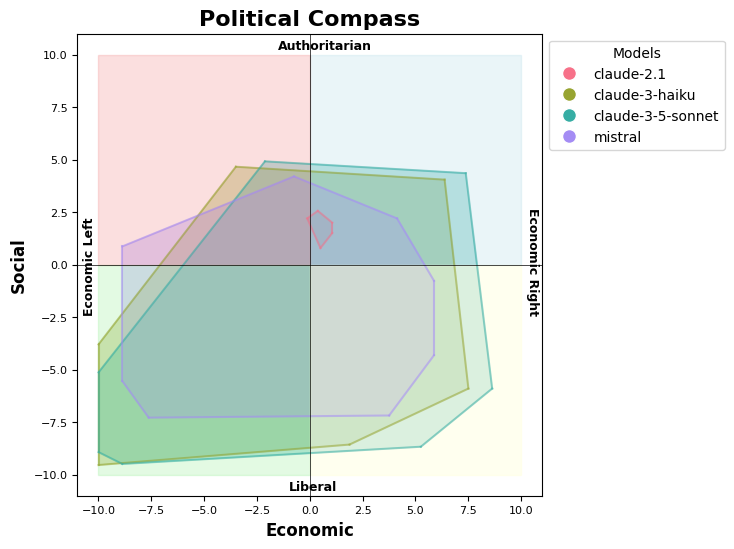

In [24]:
plot_providers(df, ['claude-2.1','claude-3-haiku', 'claude-3-5-sonnet', 'mistral'], plot_labels=False)

<module 'matplotlib.pyplot' from '/Users/dkb16129/.virtualenvs/rag/lib/python3.11/site-packages/matplotlib/pyplot.py'>

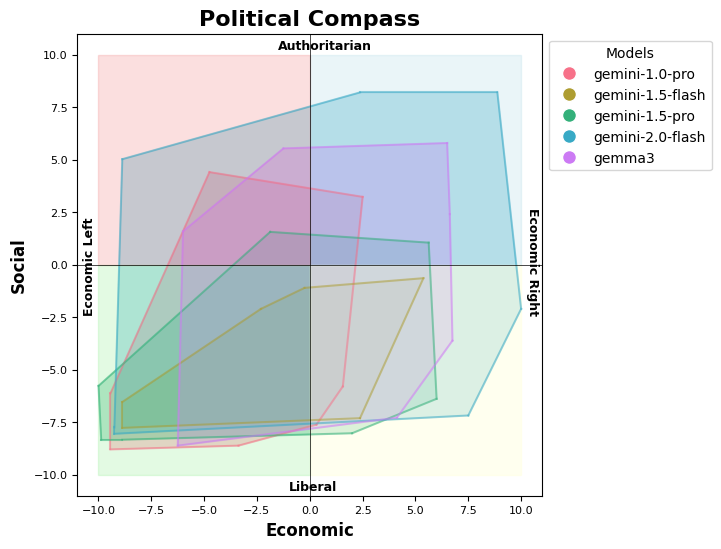

In [25]:
plot_providers(df, ['gemini-1.0-pro', 'gemini-1.5-flash', 'gemini-1.5-pro',
       'gemini-2.0-flash','gemma3'], plot_labels=False)

<module 'matplotlib.pyplot' from '/Users/dkb16129/.virtualenvs/rag/lib/python3.11/site-packages/matplotlib/pyplot.py'>

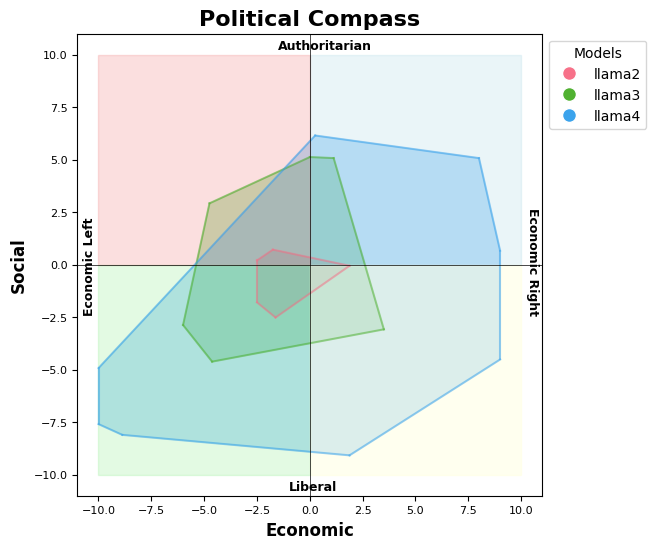

In [26]:
plot_providers(df, ['llama2', 'llama3', 'llama4'], plot_labels=False)

<module 'matplotlib.pyplot' from '/Users/dkb16129/.virtualenvs/rag/lib/python3.11/site-packages/matplotlib/pyplot.py'>

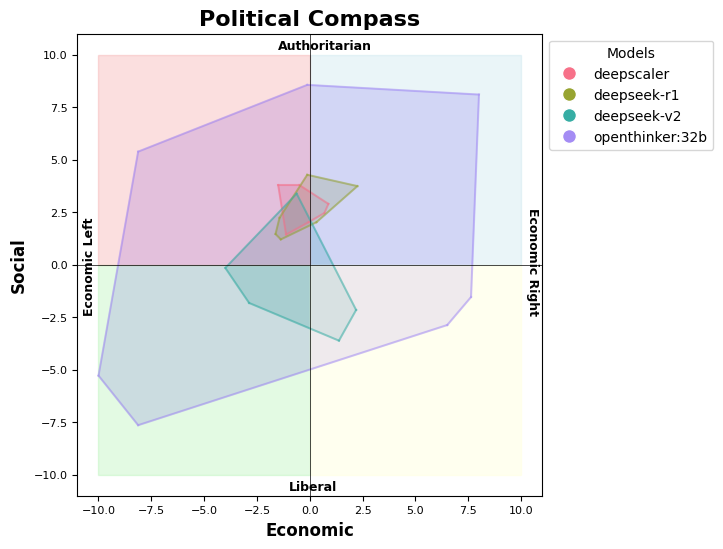

In [27]:
plot_providers(df, ['deepscaler', 'deepseek-r1', 'deepseek-v2', 'openthinker:32b'], plot_labels=False)

<module 'matplotlib.pyplot' from '/Users/dkb16129/.virtualenvs/rag/lib/python3.11/site-packages/matplotlib/pyplot.py'>

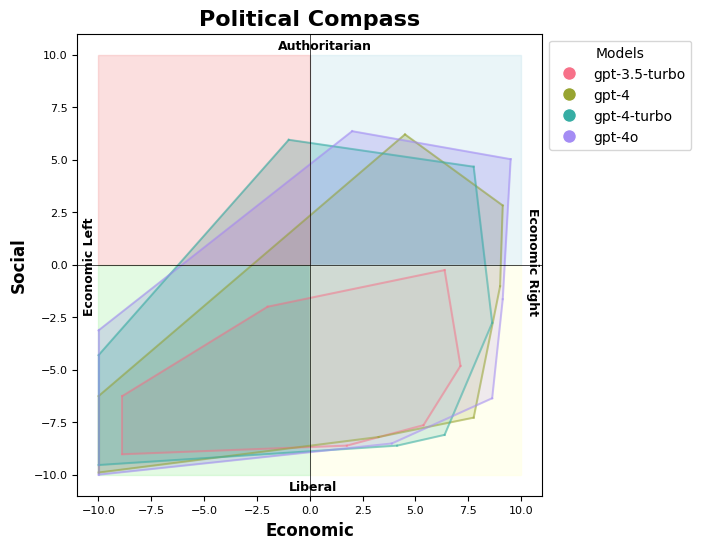

In [28]:
plot_providers(df, ['gpt-3.5-turbo', 'gpt-4','gpt-4-turbo', 'gpt-4o'], plot_labels=False)

<module 'matplotlib.pyplot' from '/Users/dkb16129/.virtualenvs/rag/lib/python3.11/site-packages/matplotlib/pyplot.py'>

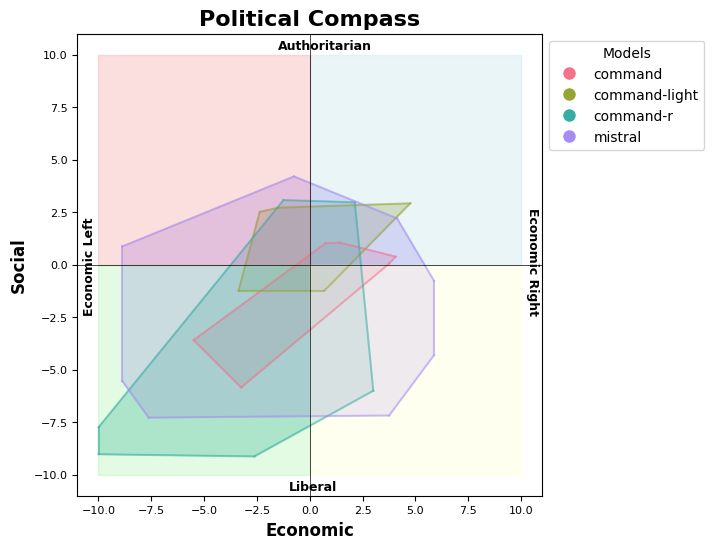

In [29]:
plot_providers(df, ['command', 'command-light', 'command-r', 'mistral'], plot_labels=False)